In [2]:
!pwd

/home/vinh/project/experiments-drift-detection/notebooks


In [1]:
import os
os.chdir("../")

In [2]:
import math
from typing import Dict, Iterable, Tuple, List
from pm4py.objects.log.obj import EventLog
import pm4py.util.xes_constants as xes
import numpy as np
from wasserstein import EMD
from collections import Counter

from src.utils.helpers import makeProgressBar

from sklearn.cluster import kmeans_plusplus

from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from strsimpy.weighted_levenshtein import WeightedLevenshtein

from scipy.signal import find_peaks

/home/vinh/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
lever = Levenshtein()
nlever = NormalizedLevenshtein()

In [4]:
def extractTraces(log: EventLog, activityName_key:str=xes.DEFAULT_NAME_KEY)-> np.ndarray:
    out = np.empty(len(log), dtype=object)
    for index, case in enumerate(log):
        out[index] = tuple(evt[activityName_key] for evt in case)
    return out

In [5]:
def postNormalizedLevenshteinDistance(trace1:Iterable[str], trace2:Iterable[str])-> float:
    """Compute the post-normalized Levenshtein distance between two traces. (Levenshtein Distance divided by the maximal length of the two traces).

    Args:
        trace1 (Iterable[str]): The first trace.
        trace2 (Iterable[str]): The second trace.

    Returns:
        float: The post-normalized Levenshtein distance of the two traces.
    """

    return nlever.distance(trace1, trace2)

In [6]:
def calcEMD(dist1:List[Tuple[Iterable[str], float]], dist2: List[Tuple[Iterable[str], float]], previous_distances:Dict[Tuple[Iterable[str],Iterable[str]],float]=None,return_distances:bool=False)->float:
    """Calculate the Earth-Mover's Distance of two distributions of traces.

    Args:
        dist1 (List[Tuple[Iterable[str], float]]): The stochastic language of the first population, represented as a list of tuples containing the trace and its probability.
        dist2 (List[Tuple[Iterable[str], float]]): The stochastic language of the second population, represented as a list of tuples containing the trace and its probability.
        previous_distances (Dict[Tuple[Iterable[str],Iterable[str]],float], optional): A dictionary mapping pairs of traces (tuples) to already computed distances. Helpful for keeping computation time low, as these are used internally instead of re-computing the distances. Defaults to None.
        return_distances (bool, optional): Whether or not a dictionary of computed distances shoud be returned. Defaults to False. If `previous_distances` was supplied, this dictionary is updated and returned.

    Returns:
        float: The computed Earth-Mover's Distance

    Examples:
    >>> from cdrift.approaches.earthmover import calcEMD
    >>> f1 = [(('a','b','d','f'),.5), (('a','c','f'),.4),(('a','b','e','f'),.1)]
    >>> f2 = [(('a','b','d','f'),.5), (('a','c','f'),.35), (('a','b','d','e','f'),.15)]
    >>> f3 = [(('a','b','d','f'),.2), (('a','c','f'),.7),(('a','b','e','f'),.1)]
    >>> calcEMD(f1,f2)
    >>> 0.049999999999999996 
    >>> calcEMD(f1,f3)
    >>> 0.14999999999999997
    """    

    #Return calculated distances for faster execution in future iterations
    # Input is formatted:
    #[(trace, probability)]
    distances = np.ones((len(dist1), len(dist2)))
    if previous_distances is None:
        previous_distances = {}
    for i, (trace1,_) in enumerate(dist1):
        for j, (trace2,_) in enumerate(dist2):
            if previous_distances.get((trace1,trace2),None) is None:
                previous_distances[(trace1,trace2)] = postNormalizedLevenshteinDistance(trace1,trace2)
            distances[i,j] = previous_distances[(trace1,trace2)]
    
    solver = EMD()
    distance = solver(
        [freq for _,freq in dist1],
        [freq for _,freq in dist2],
        distances
    )
    return distance if not return_distances else (distance, previous_distances)


In [7]:
def calculateDistSeriesStride(signal:np.ndarray, windowSize:int, stride:int=1, show_progressBar:bool=True, progressBar_pos:int=None):
    if show_progressBar:
        progress = makeProgressBar(len(signal)-(2*windowSize), "calculating earthmover values, completed windows", position=progressBar_pos)
    #Default to Zeroes, because we are looking at distances, not pvalues!
    pvals = []
    distances = {}

    i = 0
    while i < len(signal) - (2*windowSize):
        win1 = signal[i:i+windowSize]
        win2 = signal[i+windowSize:i+(2*windowSize)]
        #Convert to stochastic languages
        pop1 = [(trace,freq/len(win1)) for (trace,freq) in Counter(win1).items()]
        pop2 = [(trace,freq/len(win2)) for (trace,freq) in Counter(win2).items()]
        distance, distances = calcEMD(pop1, pop2, previous_distances=distances, return_distances=True)
        pvals.append(distance)
        if show_progressBar:
            progress.update(n=min(progress.total-progress.n, stride))
        i += stride
    if show_progressBar:
        progress.close()
    return pvals

In [8]:
def visualInspection_Stride(signal, window_size:int, step_size:int=1):
    """Automated visual inspection of distances. Used for consistent and unbiased evaluations.

    Based on the `find_peaks` algorithm of scipy.

    Args:
        signal (np.ndarray): The EMD values to inspect
        trim (int, optional): The number of values to trim from each side before detection. Defaults to 0. This is useful, because `windowSize` values at the beginning and end of the resulting EMD series default to 0, and are uninteresting and irrelevant for the inspection. If a stride value was used, the signal is already trimmed, so keep this value 0!

    Returns:
        List[int]: A list of found change point indices (integers)
    """

    # Divide width by step size because if we look for a peak with width 80 on step size 1, this corresponds to a width of 40 on step size 2
    # This could become problematic with higher step sizes since the width would go towards 0...
    peaks= find_peaks(signal, width=80/step_size)[0]

    # Correct the found indices by adding the window size that was lost
    # also multiply by step size to get location in log
    return [(x*step_size) + window_size for x in peaks]

In [9]:
from pm4py import read_xes

In [10]:
log1 = read_xes("data/bose_log.xes")
log2 = read_xes("data/sudden_trace_noise0_1000_IOR.xes")

parsing log, completed traces :: 100%|████| 1000/1000 [00:00<00:00, 2199.34it/s]


In [11]:
out1 = extractTraces(log1)
out2 = extractTraces(log2)

In [16]:
pvals1 = calculateDistSeriesStride(out1, windowSize=100)
pvals2 = calculateDistSeriesStride(out2, windowSize = 100)


calculating earthmover values, completed windows :: 100%|█| 5800/5800 [01:38<00:
calculating earthmover values, completed windows :: 100%|█| 800/800 [00:01<00:00


In [17]:
cp1 = visualInspection_Stride(pvals1, window_size=200)
cp2 = visualInspection_Stride(pvals2, window_size=200)

/tmp/ipykernel_3614171/3740852276.py:16: PeakPropertyWarning: some peaks have a width of 0
  peaks= find_peaks(signal, width=80/step_size)[0]


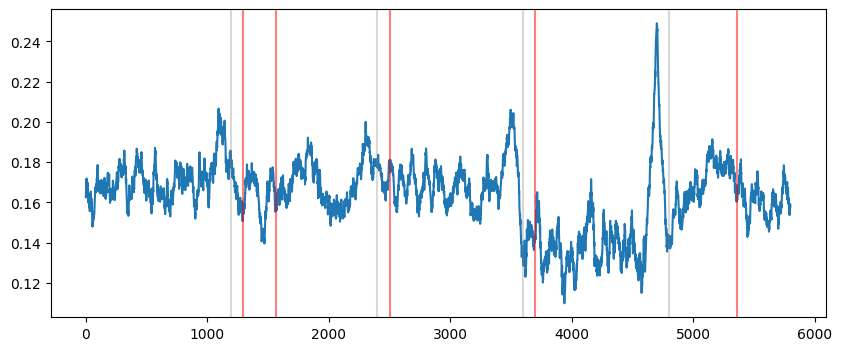

In [18]:
import matplotlib.pyplot as plt
TRUE_CHANGEPOINTS1 = [1199, 2399, 3599, 4799]
def plotPvals(sig, cp, known_cp):
    fig = plt.figure(figsize=(10,4))
    plt.plot(sig)
    for c in cp:
        plt.axvline(x=c, color="red", alpha=0.5)
    for c in known_cp:
        plt.axvline(x=c, color="grey", alpha=0.3)
    plt.show()

plotPvals(pvals1,cp1,TRUE_CHANGEPOINTS1)

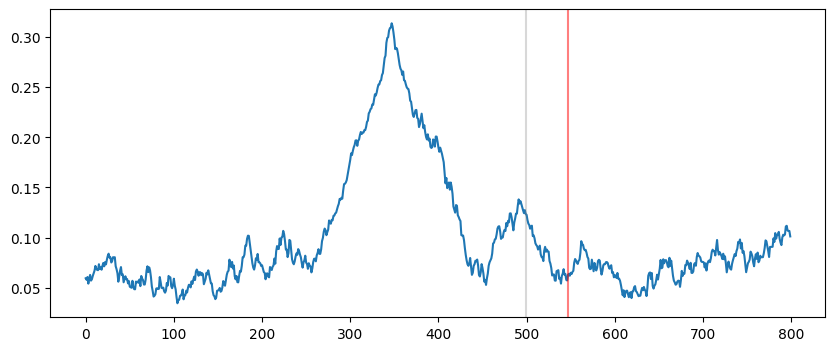

In [19]:
import matplotlib.pyplot as plt
TRUE_CHANGEPOINTS2 = [499]
def plotPvals(sig, cp, known_cp):
    fig = plt.figure(figsize=(10,4))
    plt.plot(sig)
    for c in cp:
        plt.axvline(x=c, color="red", alpha=0.5)
    for c in known_cp:
        plt.axvline(x=c, color="grey", alpha=0.3)
    plt.show()

plotPvals(pvals2,cp2,TRUE_CHANGEPOINTS2)